In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F

from CurriculumMPI import CurriculumMPI

#np.set_printoptions(precision=4)
import math
from utils import *

nS = 15
nA = 2
seed = get_current_seed()
seed = 47146882006333120128184314011326542902
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, small=5, large=1000, seed=seed)
tau = .5
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)
tmdp_1 = TMDP(river, xi, tau=.5, gamma=gamma, seed=seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Current seed for result reproducibility: 47146882006333120128184314011326542902


In [2]:
model_lr = 0.026563586934043884
pol_lr = 0.051995695341482906
episodes = 1000000
batch_size = 11
temp = 25.73110109982855
lam = 0.
final_temp = 0.02

In [3]:
{'model_lr': 0.15869281717397965,
 'pol_lr': 0.13385176875263757,
 'batch_size': 2,
 'lam': 0.7701417865047747,
 'temp': 8.376693546196126}

{'model_lr': 0.15869281717397965,
 'pol_lr': 0.13385176875263757,
 'batch_size': 2,
 'lam': 0.7701417865047747,
 'temp': 8.376693546196126}

In [4]:
curr_MPI = CurriculumMPI(tmdp, device=device)

In [5]:
curr_MPI.train(model_lr, pol_lr, batch_size=batch_size, 
                        lam=lam, temp=temp, final_temp=final_temp,
                        episodes=1000000, check_convergence=False,
                        param_decay=True)

Expected performance under current policy:  0.0
No valid pairs found
[(0.0, 0.5)]
Alpha*: 0.0 tau*: 0.5 Episode: 49 length: 24 #teleports:25
Time for bound evaluation:  0.004001140594482422
Got not null reward 5.0!
Expected performance under current policy:  0.00442707072943449
[(1, 0.5), (0.0, 0.49845), (1.0, 0.49845)]
Alpha*: 1.0 tau*: 0.49845 Episode: 83 length: 17 #teleports:17
Time for bound evaluation:  0.0010004043579101562
Got not null reward 5.0!
Expected performance under current policy:  0.008947567082941532
[(1, 0.49845), (0.0, 0.49688), (1.0, 0.49688)]
Alpha*: 1.0 tau*: 0.49688 Episode: 115 length: 18 #teleports:14
Time for bound evaluation:  0.0009996891021728516
Expected performance under current policy:  0.009156244806945324
[(1, 0.49688), (0.0, 0.49529), (1.0, 0.49529)]
Alpha*: 1.0 tau*: 0.49529 Episode: 147 length: 13 #teleports:19
Time for bound evaluation:  0.0030014514923095703
Got not null reward 5.0!
Expected performance under current policy:  0.01367457304149866

In [6]:
res = bellman_optimal_q(mdp.env.P_mat, mdp.env.reward, mdp.gamma)
Q = res["Q"]
V = compute_V_from_Q(Q, get_policy(Q))
#print(Q)

delta_pol = get_policy(Q)-get_policy(get_softmax_policy(curr_MPI.theta))
print(delta_pol)

r_s_a = compute_r_s_a(mdp.env.P_mat, mdp.env.reward)

V_Q = compute_V_from_Q(Q, get_policy(curr_MPI.Q))

V_curr = compute_V_from_Q(Q, get_softmax_policy(curr_MPI.theta))
V_ref = compute_V_from_Q(Q, get_softmax_policy(curr_MPI.theta_ref))

j_curr = compute_expected_j(V_curr, tmdp.env.mu)
j_curr_ref = compute_expected_j(V_ref, tmdp.env.mu)
j_q_curr = compute_expected_j(V_Q, tmdp.env.mu)
j_opt = compute_expected_j(V, tmdp.env.mu)
print("optimal performance: ",j_opt)
print("curriculum performance: ", j_curr)
print("reference curriculum performance: ",j_curr_ref)
print("Q curriculum performance: ",j_q_curr)

#print(get_softmax_policy(curr_MPI.theta))

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [-1.  1.]
 [-1.  1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
optimal performance:  213.3114597875864
curriculum performance:  212.1331684641334
reference curriculum performance:  212.1331684641334
Q curriculum performance:  213.13107463720968


In [7]:
print(curr_MPI.Qs[-1])

[[  49.99995603   41.31216456]
 [  44.99995523   38.03560626]
 [  40.49995335   34.50705169]
 [  36.44994971   30.99560437]
 [  32.80494271   27.57532961]
 [  29.52442579   24.83759806]
 [  26.57190166   31.13682724]
 [  23.19140207   58.670954  ]
 [  25.92387423   90.83107867]
 [  44.89893353  138.16702799]
 [  70.69570419  206.14342506]
 [ 121.81404801  308.63696747]
 [ 175.23202661  455.67485623]
 [ 269.77678581  670.27400018]
 [ 448.69000707 1008.5253648 ]]


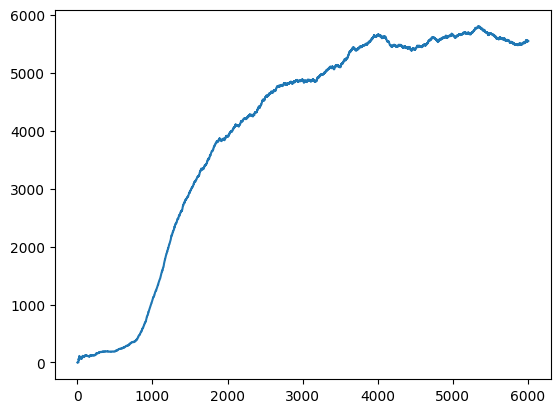

In [8]:
import matplotlib.pyplot as plt
reward_records = curr_MPI.reward_records
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 500:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-499:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
#plt.plot(reward_records)
plt.plot(average_reward)

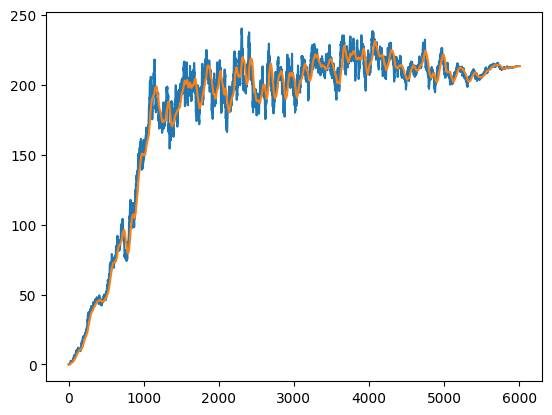

In [9]:
import matplotlib.pyplot as plt
exp_performances = curr_MPI.exp_performances
# Generate recent 50 interval average
avg_performances = []
for idx in range(len(exp_performances)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = exp_performances[:idx+1]
    else:
        avg_list = exp_performances[idx-49:idx+1]
    avg_performances.append(np.average(avg_list))
# Plot
plt.plot(exp_performances)
plt.plot(avg_performances)

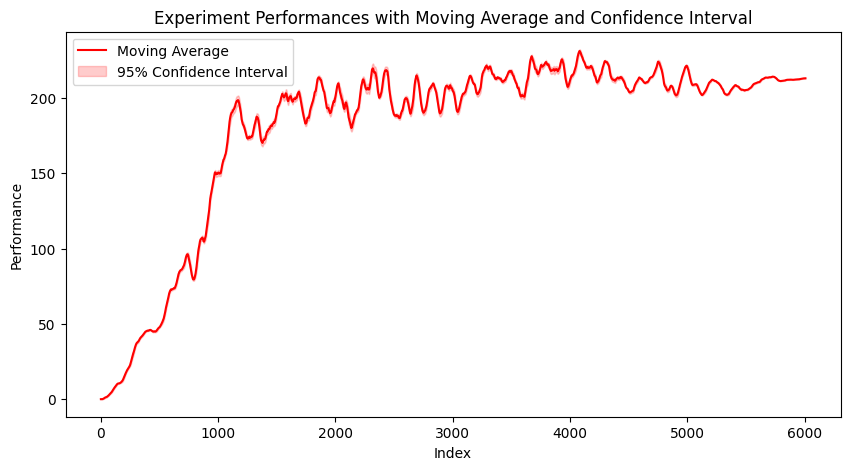

In [10]:
import matplotlib.pyplot as plt
import numpy as np

exp_performances = curr_MPI.exp_performances
# Generate recent 50 interval average
avg_performances = []
std_errors = []

for idx in range(len(exp_performances)):
    if idx < 50:
        avg_list = exp_performances[:idx+1]
    else:
        avg_list = exp_performances[idx-49:idx+1]

    average = np.average(avg_list)
    std_dev = np.std(avg_list)
    n_samples = len(avg_list)
    sem = std_dev / np.sqrt(n_samples)  # Standard Error of the Mean
    std_errors.append(sem)

    avg_performances.append(average)

# Compute the upper and lower bounds for the 95% confidence interval
ci = 1.96  # Z-score for 95% confidence
upper_bound = [avg + ci * sem for avg, sem in zip(avg_performances, std_errors)]
lower_bound = [avg - ci * sem for avg, sem in zip(avg_performances, std_errors)]

# Plot
plt.figure(figsize=(10, 5))
#plt.plot(exp_performances, label='Exp Performances')
plt.plot(avg_performances, label='Moving Average', color='r')
plt.fill_between(range(len(avg_performances)), lower_bound, upper_bound, color='r', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('Experiment Performances with Moving Average and Confidence Interval')
plt.xlabel('Index')
plt.ylabel('Performance')
plt.show()


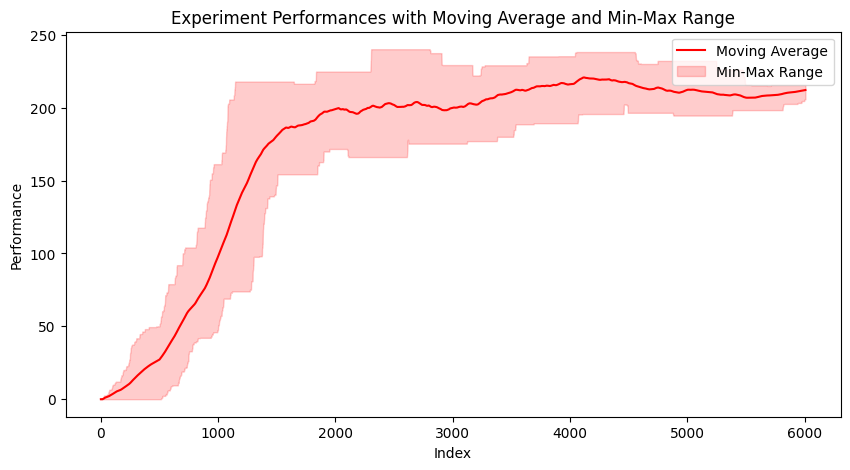

: 

In [11]:
import matplotlib.pyplot as plt
import numpy as np

exp_performances = curr_MPI.exp_performances  # Replace with your actual data
# Generate recent 50 interval average
avg_performances = []
min_values = []
max_values = []

for idx in range(len(exp_performances)):
    if idx < 500:
        window = exp_performances[:idx+1]
    else:
        window = exp_performances[idx-499:idx+1]

    average = np.average(window)
    min_val = np.min(window)
    max_val = np.max(window)

    avg_performances.append(average)
    min_values.append(min_val)
    max_values.append(max_val)

# Plot
plt.figure(figsize=(10, 5))
#plt.plot(exp_performances, label='Exp Performances')
plt.plot(avg_performances, label='Moving Average', color='r')
plt.fill_between(range(len(avg_performances)), min_values, max_values, color='r', alpha=0.2, label='Min-Max Range')
plt.legend()
plt.title('Experiment Performances with Moving Average and Min-Max Range')
plt.xlabel('Index')
plt.ylabel('Performance')
plt.show()

